In [8]:
from PIL import Image

from keras.layers import Input, Dense, Layer
from keras.models import Model
from keras.constraints import Constraint
from keras.regularizers import Regularizer

from keras import backend as K
from keras import regularizers

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import sys
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib.cm import *
from matplotlib.pyplot import imshow

import sklearn as sk
from sklearn import feature_extraction
import networkx as nx

print(keras.__version__)

2.2.4-tf


In [9]:
SYS_PATH_ADD_DIR = "/home/dhw3172/projects/water"
sys.path.append( os.path.join(SYS_PATH_ADD_DIR, "Python") )

In [10]:
from GenlassoAutoencoder import *
print(ROOT_DIR)

/home/dhw3172/projects/water


In [15]:
rast=readImage()
arr= readNpArray()
tens=readTensor()

There are 1296 pixels - dim - (48, 27) in the image /home/dhw3172/projects/water/Data/GeoData/Raster/DEM/MtlPoin_Sain_VillElev.tif
There are 1296 pixels - dim - (48, 27) in the image /home/dhw3172/projects/water/Data/GeoData/Raster/DEM/MtlPoin_Sain_VillElev.tif
There are 1296 pixels - dim - (48, 27) in the image /home/dhw3172/projects/water/Data/GeoData/Raster/DEM/MtlPoin_Sain_VillElev.tif


In [16]:
dfNodes, dfEdges = readNodeEdgeList()

In [19]:
print(dfNodes.shape)
dfNodes.head()

(1222, 4)


x          y       elev  cell
0 -73.634271  45.491354  66.989998     0
1 -73.632188  45.491354  71.010002     1
2 -73.630104  45.491354  75.839996     2
3 -73.628021  45.491354  82.610001     3
4 -73.625937  45.491354  92.000000     4

In [18]:
dfEdges.head()

from  to
0     1   0
1     2   1
2     3   2
3     4   3
4     5   4

In [22]:
import rasterio 

In [40]:
city="Mtl"
strNeigh="Poin_Sain_Vill"
rastPath=os.path.join(ROOT_DIR,"Data","GeoData","Raster", "DEM",f"{city}{strNeigh}Elev.tif")
with rasterio.open(rastPath) as dataset:
    val=dataset.dataset_mask()

In [37]:
dataset
print(dataset.closed, dataset.width, dataset.height, dataset.bounds, dataset.indexes)

True 48 27 BoundingBox(left=-73.6353125, bottom=45.436145833078776, right=-73.5353125, top=45.49239583312481) (1,)


In [28]:
val

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

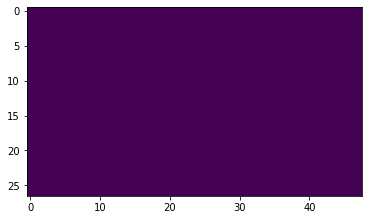

In [31]:
plt.imshow(val)

In [54]:
dataset=rasterio.open(rastPath)
dat=dataset.read(1)
print(type(dataset), dataset.closed )
dat

<class 'rasterio.io.DatasetReader'> False


array([[66.99 , 71.01 , 75.84 , ...,  7.32 ,  7.   ,  7.   ],
       [65.75 , 69.49 , 73.46 , ..., 11.57 ,  7.05 ,  7.   ],
       [62.42 , 66.77 , 71.72 , ..., 19.39 , 11.35 ,  7.   ],
       ...,
       [36.17 , 38.62 , 39.5  , ..., 17.   , 17.   , 17.   ],
       [38.85 , 40.   , 39.9  , ..., 17.   , 17.   , 17.   ],
       [38.575, 39.075, 39.   , ..., 17.   , 17.   , 17.   ]],
      dtype=float32)

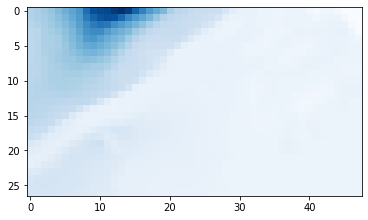

In [46]:
plt.imshow(dat,cmap=get_cmap("Blues"))

<generator object shapes at 0x7f0e19e86048>

In [60]:
dat.shape

(27, 48)

In [81]:

G = nx.grid_2d_graph(dat.shape[0],dat.shape[1])

edges=[ (u,v) for u,v,dat in G.edges(data=True) ] #nodes have label (i,j) where i and j represent the x,y coordinate in a regular grid if (u[0], u[1]] for u,v in G.edges())
print(len(edges))
edges[:4]

2517


[((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2))]

/home/dhw3172/anaconda3/envs/pyAudio37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


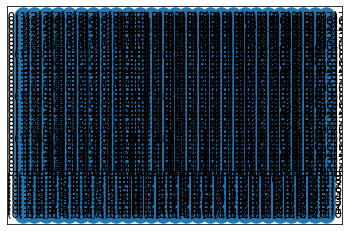

In [80]:
nx.draw_networkx(G,pos={i: i  for i in G.nodes()} )

In [86]:
adjMat=nx.adj_matrix(G)
adjMat

<1296x1296 sparse matrix of type '<class 'numpy.int64'>'
	with 5034 stored elements in Compressed Sparse Row format>

In [89]:
np.where(adjMat.todense() != 0 )

(array([   0,    0,    1, ..., 1294, 1295, 1295]),
 array([   1,   48,    0, ..., 1295, 1247, 1294]))

In [104]:
dfEdges=pd.DataFrame( { "start": [ u for u,v, dat in G.edges(data=True)],
                      "end": [ v for u,v, dat in G.edges(data=True)] } )

dfEdges.head()

start     end
0  (0, 0)  (1, 0)
1  (0, 0)  (0, 1)
2  (0, 1)  (1, 1)
3  (0, 1)  (0, 2)
4  (0, 2)  (1, 2)

In [106]:
dfEdges.shape

(2517, 2)

In [117]:
randMat=np.random.rand(rast.size[1],rast.size[0])  #need to take transpose
print(randMat.shape)

(27, 48)


In [115]:
idxStarti=dfEdges.loc[0, "start"][0]
idxStartj=dfEdges.loc[0, "start"][1]

idxEndi=dfEdges.loc[0, "end"][0]
idxEndj=dfEdges.loc[0, "end"][1]

In [116]:
print( randMat[ idxStarti, idxStartj ], randMat[ idxEndi, idxEndj ] )

0.9242656935922445 0.6747368621697865


In [122]:
print( max( [  u[0]  for u in G.nodes() ] ), max( [  u[1]  for u in G.nodes() ] ) )

26 47
